<a href="https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/resources/02_production_details_on_image_cleaner_widget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.9MB/s 
     |████████████████████████████████| 1.2MB 14.5MB/s 
     |████████████████████████████████| 204kB 29.0MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

# Understand the ImageCleaner widget

Search and load the images

In [4]:
# key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [5]:
! pip install git+https://github.com/vtecftwy/ecutils.git@develop -q
from ecutils import ml
path_to_config = Path('/content/gdrive/MyDrive/fastai/config-api-keys.cfg')
key = ml.get_config_value('azure', 'fastai-image-search-2021-1', path_to_config_file=path_to_config)

In [9]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

Our folder has image files, as we'd expect:

In [11]:
fns = get_image_files(path)
fns

(#403) [Path('bears/black/00000045.jpg'),Path('bears/black/00000087.jpg'),Path('bears/black/00000017.jpg'),Path('bears/black/00000122.jpg'),Path('bears/black/00000052.jpg'),Path('bears/black/00000043.jpg'),Path('bears/black/00000099.jpg'),Path('bears/black/00000041.jpg'),Path('bears/black/00000104.jpg'),Path('bears/black/00000085.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [12]:
failed = verify_images(fns)
failed

(#6) [Path('bears/black/00000028.jpg'),Path('bears/black/00000089.jpg'),Path('bears/teddy/00000098.jpg'),Path('bears/grizzly/00000014.jpg'),Path('bears/grizzly/00000123.jpg'),Path('bears/grizzly/00000042.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [13]:
failed.map(Path.unlink);

Now that we have downloaded some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called `DataLoaders`.

## From Data to DataLoaders

In [14]:
bears = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=parent_label,
                  item_tfms=Resize(128))

In [16]:
# bears.summary(path)

In [18]:
dls = bears.dataloaders(path)

['black', 'grizzly', 'teddy']

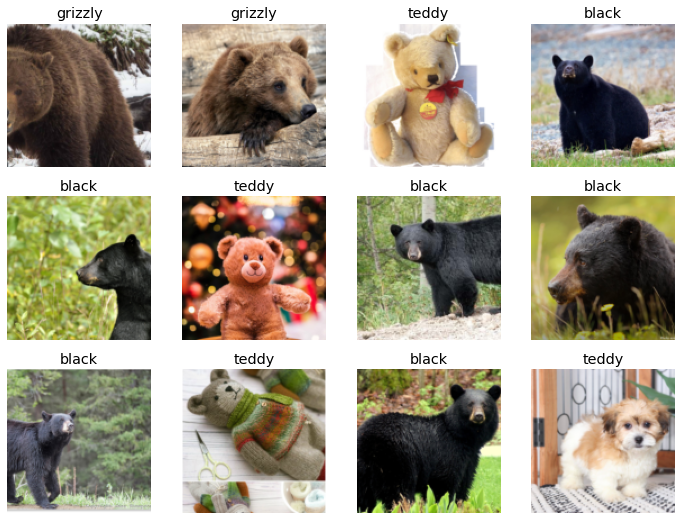

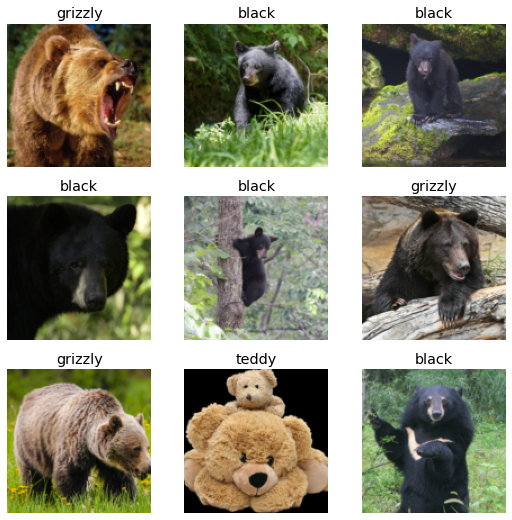

In [21]:
# dls.train.dataset, dls.valid.dataset
# dls.train.items[0:5], dls.valid.items[0:5], 
# dls.n, dls.train.n, dls.valid.n
display(dls.vocab)
dls.train.show_batch(max_n=12, ncols=4)
dls.valid.show_batch(max_n=9, ncols=3)

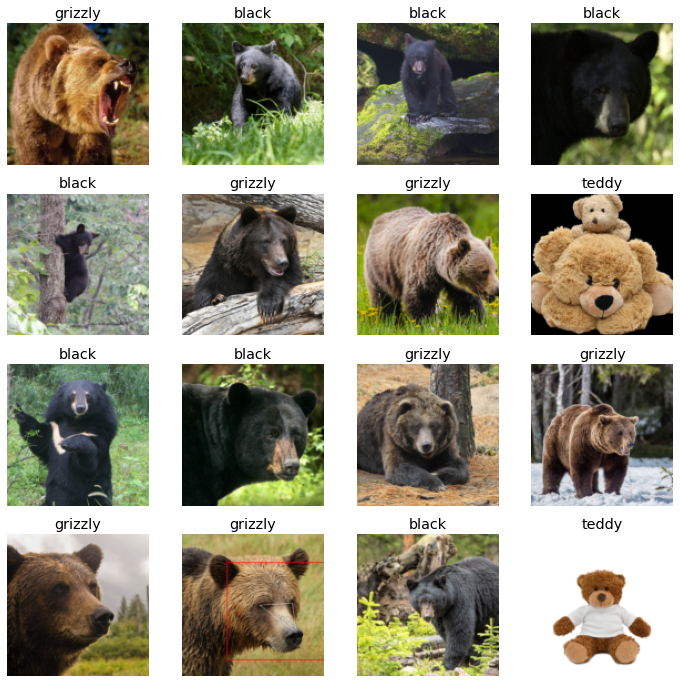

In [22]:
dls.valid.show_batch(max_n=16, nrows=4)

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in `chapter_intro` to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [23]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                  batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [24]:
metric_list = [error_rate, accuracy, Precision(average='macro'),Recall(average='macro'), 
               Jaccard(average='macro'), RocAuc(average='macro'), ]
learn = cnn_learner(dls, resnet18, metrics=metric_list)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Key attributes of `ImageClassifierCleaner`:
- `fns`: list (`L`) for the selected images' `Path`. By defaults, `fns` has 30 images' `Path`.

Key methods of  `ImageClassifierCleaner`:
- `.values()`: returns a `L` with the action to perform for each images in fns
- `.delete()`: returns a `L` with the indexes of the images selected to delete
- `.change()`: returns a `L` of tuples (index of image to allocate to new class, class)


In [26]:
cleaner.fns

(#30) [Path('bears/black/00000127.jpg'),Path('bears/black/00000015.jpg'),Path('bears/black/00000037.jpg'),Path('bears/black/00000109.png'),Path('bears/black/00000099.jpg'),Path('bears/black/00000133.jpg'),Path('bears/black/00000107.jpg'),Path('bears/black/00000119.jpg'),Path('bears/black/00000141.jpg'),Path('bears/black/00000050.jpg')...]

In [28]:
cleaner.values()

(#30) ['<Keep>','<Keep>','<Keep>','<Keep>','<Keep>','<Keep>','<Keep>','<Keep>','<Keep>','<Keep>'...]

In [ ]:
cleaner.delete()

(#3) [3,6,8]

In [ ]:
cleaner.fns[cleaner.delete()]

(#3) [Path('bears/black/00000128.png'),Path('bears/black/00000132.jpg'),Path('bears/black/00000146.jpg')]

In [ ]:
cleaner.change()

(#3) [(0, 'grizzly'),(4, 'grizzly'),(5, 'teddy')]

By using `cleaner.delete()` and `cleaner.change()` we can delete or move images.

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

Source code for cleaner ([here](https://github.com/fastai/fastai/blob/master/fastai/vision/widgets.py#L44))
``` python
class ImagesCleaner:
    "A widget that displays all images in `fns` along with a `Dropdown`"
    def __init__(self, opts=(), height=128, width=256, max_n=30):
        opts = ('<Keep>', '<Delete>')+tuple(opts)
        store_attr('opts,height,width,max_n')
        self.widget = carousel(width='100%')

    def set_fns(self, fns):
        self.fns = L(fns)[:self.max_n]
        ims = parallel(_open_thumb, self.fns, h=self.height, w=self.width, progress=False,
                       n_workers=min(len(self.fns)//10,defaults.cpus))
        self.widget.children = [VBox([widget(im, height=f'{self.height}px'), Dropdown(
            options=self.opts, layout={'width': 'max-content'})]) for im in ims]

    def _ipython_display_(self): display(self.widget)
    def values(self): return L(self.widget.children).itemgot(1).attrgot('value')
    def delete(self): return self.values().argwhere(eq('<Delete>'))
    def change(self):
        idxs = self.values().argwhere(not_(in_(['<Delete>','<Keep>'])))
        return idxs.zipwith(self.values()[idxs])

@delegates(ImagesCleaner)
class ImageClassifierCleaner(GetAttr):
    "A widget that provides an `ImagesCleaner` with a CNN `Learner`"
    def __init__(self, learn, **kwargs):
        vocab = learn.dls.vocab
        self.default = self.iw = ImagesCleaner(vocab, **kwargs)
        self.dd_cats = Dropdown(options=vocab)
        self.dd_ds   = Dropdown(options=('Train','Valid'))
        self.iwis = _get_iw_info(learn,0),_get_iw_info(learn,1)
        self.dd_ds.observe(self.on_change_ds, 'value')
        self.dd_cats.observe(self.on_change_ds, 'value')
        self.on_change_ds()
        self.widget = VBox([self.dd_cats, self.dd_ds, self.iw.widget])

    def _ipython_display_(self): display(self.widget)
    def on_change_ds(self, change=None):
        info = L(o for o in self.iwis[self.dd_ds.index] if o[1]==self.dd_cats.value)
        self.iw.set_fns(info.sorted(2, reverse=True).itemgot(0))
```